In [17]:
import pandas as pd
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.report.report_deco import ReportDeco
from lightautoml.tasks import Task
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score
)

import shap
import joblib
from collections import Counter

In [24]:
N = 1 # минимальная рассматриваемая длина последовательности

In [3]:
train_uid = pd.read_csv('events_train.csv')
test_uid = pd.read_csv('events_valid.csv')

In [4]:
target = pd.read_csv('train_targets.csv')
target = target[target['count'] >= N]
target

,viewer_uid,age,sex,age_class,count
0,10087154,30,male,1,2
1,10908708,25,female,1,4
2,10190464,34,male,2,18
3,10939673,25,male,1,1
4,10288257,48,male,3,2
...,...,...,...,...,...
180007,10237402,43,female,3,4
180008,10796936,32,male,2,71
180009,10684284,28,male,1,7
180010,10031093,50,female,3,2


In [5]:
train_uid = train_uid[train_uid['0'].isin(target['viewer_uid'])]
test_uid = test_uid[test_uid['0'].isin(target['viewer_uid'])]
train_uid.shape, test_uid.shape

((162010, 2), (18002, 2))

In [6]:
video = pd.read_csv('video_info_v2.csv')
video

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,763,764,765,766,767,rutube_video_id,title,category,duration,author_id
0,0,0.051871,-0.138572,-0.010533,0.081957,0.052449,0.011842,0.020253,0.088911,0.256520,...,0.221178,-0.024534,0.046244,-0.042396,0.031988,video_185549,Как собрать букет из мыльных тюльпанов - Силик...,Хобби,1559160,1015054
1,1,0.035020,0.132503,-0.019875,0.010344,0.089535,0.029232,0.122328,-0.001245,0.018507,...,0.095075,0.043702,0.092635,-0.026834,-0.135017,video_111035,"Осторожно, Киберземляне!, 1 сезон, 12 серия",Сериалы,1320007,1002180
2,2,0.102648,0.021863,-0.017601,0.032409,0.073079,-0.015575,0.186894,-0.029932,-0.055004,...,0.091078,-0.008273,0.083752,-0.051263,-0.086077,video_476517,ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...,Хобби,606145,1095337
3,3,-0.016647,0.197917,-0.016216,-0.073096,-0.001365,-0.093330,0.053322,-0.030007,-0.048885,...,0.242268,0.026703,0.013972,0.149603,-0.070358,video_157198,"Хороший лжец (фильм, 2019)",Фильмы,6577440,1043618
4,4,0.041907,0.170176,-0.020355,0.021433,0.059289,0.018109,0.011155,0.032854,0.061599,...,0.039800,0.030024,0.051284,-0.058650,-0.055291,video_289824,Нашего старого гнобят по-всякому,Развлечения,859493,1009535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481475,481475,-0.188904,-0.066786,-0.008377,0.147394,-0.004622,-0.017422,0.090313,-0.012335,-0.027706,...,0.000522,-0.068513,-0.058606,-0.052690,-0.009973,video_196126,14. Landscape Layer Blend,Дизайн,462000,1121338
481476,481476,-0.022063,0.169486,-0.014611,0.002445,0.113046,-0.108387,0.116606,0.021941,0.033342,...,0.088374,0.039773,0.050880,-0.075038,-0.121570,video_390909,Рихард Штраус: Завтра! — Людмила Рубинская,Музыка,227628,1043510
481477,481477,0.030406,0.043699,-0.019820,0.084245,0.042511,0.073490,-0.030227,0.029015,-0.053711,...,0.058893,0.013293,0.110201,-0.032270,-0.061133,video_326364,"Поймай Тинипин! Королевство эмоций, 2 серия. С...",Мультфильмы,744576,1002799
481478,481478,0.029685,0.020378,-0.021121,-0.023906,0.054851,0.037577,0.064446,0.026065,0.037257,...,-0.020561,0.037373,0.050073,0.007539,-0.070740,video_374957,ВОРКУТА. 1 СЕРИЯ. УЖАСЫ. ПСИХОЛОГИЧЕСКИЙ ТРИЛЛЕР,Люди и блоги,2597385,1008386


# Baseline

In [178]:
events = pd.read_csv('train_events.csv')
train_events = events[events['viewer_uid'].isin(train_uid['0'])]
val_events = events[events['viewer_uid'].isin(test_uid['0'])]

train_events = train_events.merge(video[['author_id', 'rutube_video_id']], how='left')
train_events = train_events.merge(target, on='viewer_uid', how='inner')
train_events = train_events.drop(columns=['event_timestamp','rutube_video_id', 'ua_device_type', 'ua_client_type', 'ua_os',\
                                           'ua_client_name', 'total_watchtime'])
train_events.head()

,region,viewer_uid,author_id,Unnamed: 0,age,sex,age_class,count
0,Chelyabinsk,10067243,1009219,33325,20,female,0,43
1,Chelyabinsk,10067243,1009219,33325,20,female,0,43
2,Chelyabinsk,10067243,1009257,33325,20,female,0,43
3,Chelyabinsk,10067243,1002256,33325,20,female,0,43
4,Chelyabinsk,10067243,1056700,33325,20,female,0,43


In [179]:
def get_mode(row):
    counter = Counter(row)
    (most_common, _) = counter.most_common(1)[0]
    
    return most_common

In [180]:
author_median_age = train_events.groupby('author_id')['age'].median()
author_sex_mode = train_events.groupby('author_id')['sex'].apply(get_mode)

author_sex_mode.name = 'sex_mode'
author_median_age.name = 'median_age'
author_info = author_sex_mode.to_frame().join(author_median_age)

In [181]:
val_events = val_events.merge(video[['rutube_video_id', 'author_id']])
val_events = val_events.drop(['event_timestamp','rutube_video_id', 'ua_device_type', 'ua_client_type', 'ua_os',\
                                           'ua_client_name', 'total_watchtime'], axis=1)
val_events = val_events.join(author_info, on='author_id', how='left')
val_events.head()

,region,viewer_uid,author_id,sex_mode,median_age
0,Komi,10100618,1002256,female,32.0
1,Komi,10100618,1009257,female,32.0
2,St.-Petersburg,10077869,1009257,female,32.0
3,Komi,10100618,1009257,female,32.0
4,St.-Petersburg,10077869,1009257,female,32.0


In [182]:
median_age_predict = val_events.groupby('viewer_uid')['median_age'].median()
mode_sex_predict = val_events.groupby('viewer_uid')['sex_mode'].apply(get_mode)

predicts = median_age_predict.to_frame().join(mode_sex_predict)
predicts = predicts.loc[test_uid['0']]


predicts['sex_mode'] = predicts['sex_mode'].fillna(author_info['sex_mode'].mode()[0])
predicts['median_age'] = predicts['median_age'].fillna(author_info['median_age'].median())

age_class_bins = [9, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
predicts['age_class'] = pd.cut(predicts['median_age'], bins=age_class_bins, labels=[0, 1, 2, 3])
predicts = predicts.reset_index()

In [183]:
val_targets = target[target['viewer_uid'].isin(test_uid['0'])]
val_targets = val_targets.sort_values(by='viewer_uid').reset_index(drop=True)
predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

In [184]:
f1_weighted = f1_score(val_targets['age_class'], predicts['age_class'], average='weighted')
accuracy = accuracy_score(val_targets['sex'], predicts['sex_mode'])

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4727 
Accuracy = 0.7667 
Final Score = 0.5609


# CoLEs

In [60]:
data = pd.read_csv(f'coles_embeds_{N}.csv')
data

,viewer_uid,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,10000001,-0.874619,0.568339,-0.259598,0.556368,-0.825182,0.131623,0.035668,-0.007617,-0.290320,...,-0.182111,-0.649282,-0.114269,-0.115634,0.968623,-0.708113,-0.208587,0.716913,-0.163581,-0.134808
1,10000002,-0.044254,0.317196,-0.147869,-0.355747,-0.051187,0.100852,-0.054936,0.234443,-0.101574,...,-0.479164,0.423107,-0.216688,0.400767,0.197775,-0.772445,0.728602,0.574008,-0.104216,-0.160956
2,10000004,-0.145912,-0.018076,0.410701,-0.370426,-0.209742,0.117598,0.054023,-0.295967,-0.135544,...,-0.104378,0.633831,0.240649,-0.145220,0.051780,0.440781,0.979661,0.468421,0.145811,0.148609
3,10000005,0.154108,-0.054118,0.003008,-0.009116,-0.700938,-0.030377,-0.023446,0.210649,-0.027704,...,-0.039632,-0.522801,-0.111834,0.018125,-0.255256,0.070824,-0.022402,-0.138530,0.006456,-0.479754
4,10000006,0.153941,-0.134025,0.014343,0.136995,-0.508813,-0.007653,0.008893,-0.355681,-0.029373,...,-0.043969,-0.865313,-0.003614,-0.011975,-0.246524,0.062054,-0.021597,-0.132570,0.005075,-0.374244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,11140828,0.156320,-0.064896,0.000653,-0.139804,-0.759027,-0.007838,-0.013510,-0.499339,-0.028844,...,-0.163784,-0.531052,-0.103420,-0.005419,-0.102742,-0.176833,-0.010706,-0.363023,0.004577,-0.328300
180008,11140869,0.156085,-0.077279,0.001762,-0.078894,-0.728836,-0.007729,-0.013884,-0.486920,-0.028838,...,-0.107126,-0.519496,-0.097244,-0.005668,-0.121077,-0.158526,-0.014388,-0.358790,0.004545,-0.143886
180009,11140872,0.162901,-0.160406,0.621567,0.156332,-0.736719,0.021615,0.075050,0.194802,-0.047044,...,-0.101097,0.854629,-0.008308,-0.007860,-0.100371,-0.513921,0.104692,-0.158289,0.002772,-0.882714
180010,11140875,0.154879,-0.080224,-0.024407,0.561927,-0.492113,-0.007339,-0.016951,-0.302682,-0.028671,...,-0.209841,-0.403031,-0.052564,-0.004862,-0.124468,-0.151633,-0.019059,-0.304170,0.003808,0.091245


In [61]:
test = data[data['viewer_uid'].isin(list(test_uid['0']))]
train = data[data['viewer_uid'].isin(list(train_uid['0']))]
train.shape, test.shape

((162010, 257), (18002, 257))

In [62]:
train = train.merge(target, on='viewer_uid')
test = test.merge(target, on='viewer_uid')
train.shape, test.shape

((162010, 261), (18002, 261))

In [63]:
train['sex'] = train['sex'].apply(lambda x: 0 if x=='male' else 1)
test['sex'] = test['sex'].apply(lambda x: 0 if x=='male' else 1)

## Обучение модели на предсказание пола

In [65]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age_class', 'viewer_uid', 'age']).copy()
roles = {'target': 'sex'}
task = Task('binary')

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred = automl.fit_predict(train_pd, roles=roles, verbose=1)
test_pred = automl.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex']))
train_pred = automl.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex']))

[01:43:28] Stdout logging level is INFO.
[01:43:28] Task: binary

[01:43:28] Start automl preset with listed constraints:
[01:43:28] - time: 1000.00 seconds
[01:43:28] - CPU: 4 cores
[01:43:28] - memory: 16 GB

[01:43:28] Train data shape: (162010, 258)




libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


[01:43:50] Layer 1 train process start. Time left 977.88 secs
[01:43:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:44:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.791786100747184
[01:44:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:44:23] Time left 945.32 secs

[01:44:51] Selector_LightGBM fitting and predicting completed
[01:44:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:46:42] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8039063862468807
[01:46:42] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:46:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[01:47:06] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[01:47:06] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[01:48:49] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.80292606162569
[01:48:49] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicti

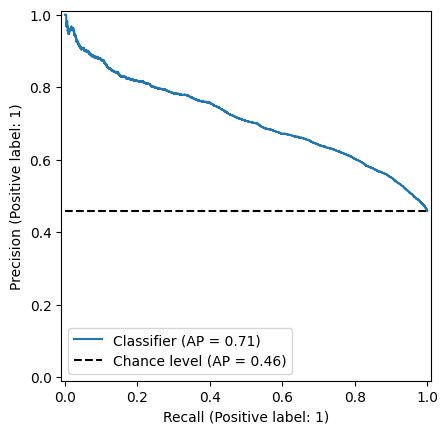

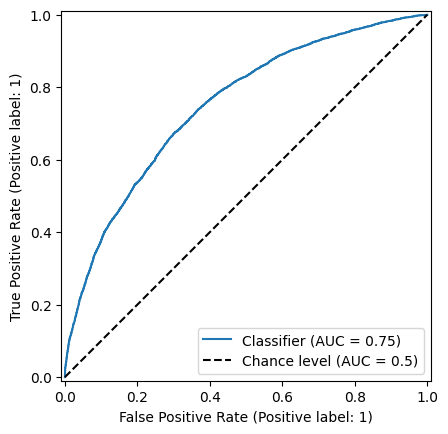

In [66]:
PrecisionRecallDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)
RocCurveDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)

In [72]:
best_tr = 0
best_ac = 0
for tr in np.linspace(0.0, 1.0, 1001):
    if True:
        ac = accuracy_score(test.sex.values, test_pred.data[:, 0] > tr)
        if best_ac < ac:
            best_ac = ac
            best_tr = tr
            
best_ac

0.6872014220642151

## Обучение модели на предсказание возраста

In [68]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age', 'viewer_uid', 'sex']).copy()
roles = {'target': 'age_class'}
task = Task('multiclass')

automl2 = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred2 = automl2.fit_predict(train_pd, roles=roles, verbose=1)
test_pred2 = automl2.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex']))
train_pred2 = automl2.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex']))

[01:54:30] Stdout logging level is INFO.
[01:54:30] Task: multiclass

[01:54:30] Start automl preset with listed constraints:
[01:54:30] - time: 1000.00 seconds
[01:54:30] - CPU: 4 cores
[01:54:30] - memory: 16 GB

[01:54:30] Train data shape: (162010, 258)




libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS


[01:55:05] Layer 1 train process start. Time left 965.14 secs
[01:55:06] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:56:18] Time limit exceeded after calculating fold 1

[01:56:18] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.1353611790324394
[01:56:18] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:56:18] Time left 892.15 secs

[01:57:32] Selector_LightGBM fitting and predicting completed
[01:57:33] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:59:26] Time limit exceeded after calculating fold 1

[01:59:26] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.1223946554430846
[01:59:26] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:59:26] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[02:01:04] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.1209515083453332
[02:01:04] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[02:01:04] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ..

In [69]:
f1_weighted = f1_score(train.age_class.values, np.argmax(train_pred2.data, axis=1), average='weighted')
f1_weighted

0.5454557891577746

In [70]:
f1_weighted = f1_score(test.age_class.values, np.argmax(test_pred2.data, axis=1), average='weighted')
f1_weighted

0.39637297134924404

In [71]:
final_score = 0.7 * f1_weighted + 0.3 * best_ac
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {best_ac:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.3964 
Accuracy = 0.6872 
Final Score = 0.4836


# Agg

In [21]:
data = pd.read_csv('events_agg.csv')
data

,viewer_uid,total_watchtime_q0,total_watchtime_q1,total_watchtime_q2,total_watchtime_q3,total_watchtime_q4,latitude_q0,latitude_q1,latitude_q2,latitude_q3,...,how_many_times_watche_median,how_many_times_watche_min,how_many_times_watche_max,how_many_times_watche_prod,med_age_sum,med_age_mean,med_age_median,med_age_min,med_age_max,med_age_prod
0,10000001,562.0,2187.50,4003.0,4953.50,6932.0,55.751244,55.751244,55.751244,55.751244,...,0.862727,0.117972,1.577017,0.000094,589.0,31.000000,31.0,31.0,31.0,2.167066e+28
1,10000002,80.0,1190.00,1210.0,1310.00,6688.0,55.751244,55.751244,55.751244,55.751244,...,0.995174,0.010093,0.999802,0.006497,299.0,33.222222,33.0,33.0,34.0,4.926692e+13
2,10000004,81.0,481.75,613.0,2425.00,4778.0,55.751244,55.751244,55.751244,59.226973,...,0.496560,0.082067,1.890750,0.000100,468.0,39.000000,39.0,39.0,39.0,1.238156e+19
3,10000005,212.0,212.00,212.0,212.00,212.0,55.349427,55.349427,55.349427,55.349427,...,0.403739,0.403739,0.403739,0.403739,42.0,42.000000,42.0,42.0,42.0,4.200000e+01
4,10000006,971.0,971.00,971.0,971.00,971.0,59.127117,59.127117,59.127117,59.127117,...,0.821611,0.821611,0.821611,0.821611,32.0,32.000000,32.0,32.0,32.0,3.200000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,11140828,1475.0,1475.00,1475.0,1475.00,1475.0,59.937500,59.937500,59.937500,59.937500,...,3.873221,3.873221,3.873221,3.873221,38.0,38.000000,38.0,38.0,38.0,3.800000e+01
180008,11140869,1305.0,1305.00,1305.0,1305.00,1305.0,59.937500,59.937500,59.937500,59.937500,...,3.426816,3.426816,3.426816,3.426816,38.0,38.000000,38.0,38.0,38.0,3.800000e+01
180009,11140872,43.0,49.75,62.0,74.75,83.0,54.853280,54.853280,54.853280,54.853280,...,0.164840,0.112819,0.227397,0.000668,160.0,40.000000,40.0,39.0,41.0,2.556801e+06
180010,11140875,1115.0,1115.00,1115.0,1115.00,1115.0,55.751244,55.751244,55.751244,55.751244,...,2.927892,2.927892,2.927892,2.927892,38.0,38.000000,38.0,38.0,38.0,3.800000e+01


In [22]:
test = data[data['viewer_uid'].isin(list(test_uid['0']))]
train = data[data['viewer_uid'].isin(list(train_uid['0']))]
train.shape, test.shape

((162010, 67), (18002, 67))

In [24]:
train = train.merge(target, on='viewer_uid')
test = test.merge(target, on='viewer_uid')
train.shape, test.shape

((162010, 71), (18002, 71))

In [25]:
train['sex'] = train['sex'].apply(lambda x: 0 if x=='male' else 1)
test['sex'] = test['sex'].apply(lambda x: 0 if x=='male' else 1)

## Обучение модели на предсказание пола

In [53]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age_class', 'viewer_uid', 'age', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']).copy()
roles = {'target': 'sex'}
task = Task('binary')

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred = automl.fit_predict(train_pd, roles=roles, verbose=1)
test_pred = automl.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))
train_pred = automl.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))

[01:21:01] Stdout logging level is INFO.
[01:21:01] Task: binary

[01:21:01] Start automl preset with listed constraints:
[01:21:01] - time: 1000.00 seconds
[01:21:01] - CPU: 4 cores
[01:21:01] - memory: 16 GB

[01:21:01] Train data shape: (162010, 63)




libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS


[01:21:08] Layer 1 train process start. Time left 993.47 secs
[01:21:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:21:22] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.819045684718344
[01:21:22] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:21:22] Time left 979.40 secs

[01:21:29] Selector_LightGBM fitting and predicting completed
[01:21:35] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:22:09] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8324395761057839
[01:22:09] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:22:09] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 184.40 secs
[01:25:17] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[01:25:17] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[01:25:42] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8321312275665542
[01:25:42] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and pred

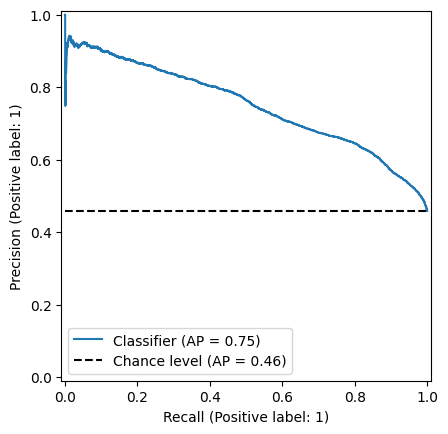

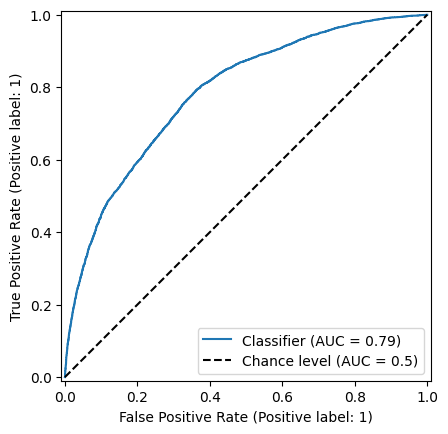

In [54]:
PrecisionRecallDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)
RocCurveDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)

In [55]:
best_tr = 0
best_ac = 0
for tr in np.linspace(0.0, 1.0, 1001):
    if True:
        ac = accuracy_score(test.sex.values, test_pred.data[:, 0] > tr)
        if best_ac < ac:
            best_ac = ac
            best_tr = tr
            
best_ac

0.7105321630929897

## Обучение модели на предсказание возраста

In [57]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age', 'viewer_uid', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']).copy()
roles = {'target': 'age_class'}
task = Task('multiclass')

automl2 = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred2 = automl2.fit_predict(train_pd, roles=roles, verbose=1)
test_pred2 = automl2.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))
train_pred2 = automl2.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))

[01:33:07] Stdout logging level is INFO.
[01:33:07] Task: multiclass

[01:33:07] Start automl preset with listed constraints:
[01:33:07] - time: 1000.00 seconds
[01:33:07] - CPU: 4 cores
[01:33:07] - memory: 16 GB

[01:33:07] Train data shape: (162010, 63)

[01:33:14] Layer 1 train process start. Time left 993.20 secs
[01:33:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:34:14] Time limit exceeded after calculating fold 0

[01:34:14] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.0430402082374326
[01:34:14] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:34:14] Time left 933.16 secs

[01:34:32] Selector_LightGBM fitting and predicting completed
[01:34:37] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:35:52] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.0337984593234917
[01:35:52] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:35:52] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget

In [58]:
f1_weighted = f1_score(test.age_class.values, np.argmax(test_pred2.data, axis=1), average='weighted')
f1_weighted

0.459994379101036

Подсчитаем итоговый скор

In [59]:
final_score = 0.7 * f1_weighted + 0.3 * best_ac
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {best_ac:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4600 
Accuracy = 0.7105 
Final Score = 0.5352


# Agg + CoLES

In [7]:
data1 = pd.read_csv('events_agg.csv')
data2 = pd.read_csv(f'coles_embeds_{N}.csv')
data = data1.merge(data2, on='viewer_uid')
data

,viewer_uid,total_watchtime_q0,total_watchtime_q1,total_watchtime_q2,total_watchtime_q3,total_watchtime_q4,latitude_q0,latitude_q1,latitude_q2,latitude_q3,...,246,247,248,249,250,251,252,253,254,255
0,10000001,562.0,2187.50,4003.0,4953.50,6932.0,55.751244,55.751244,55.751244,55.751244,...,-0.182111,-0.649282,-0.114269,-0.115634,0.968623,-0.708113,-0.208587,0.716913,-0.163581,-0.134808
1,10000002,80.0,1190.00,1210.0,1310.00,6688.0,55.751244,55.751244,55.751244,55.751244,...,-0.479164,0.423107,-0.216688,0.400767,0.197775,-0.772445,0.728602,0.574008,-0.104216,-0.160956
2,10000004,81.0,481.75,613.0,2425.00,4778.0,55.751244,55.751244,55.751244,59.226973,...,-0.104378,0.633831,0.240649,-0.145220,0.051780,0.440781,0.979661,0.468421,0.145811,0.148609
3,10000005,212.0,212.00,212.0,212.00,212.0,55.349427,55.349427,55.349427,55.349427,...,-0.039632,-0.522801,-0.111834,0.018125,-0.255256,0.070824,-0.022402,-0.138530,0.006456,-0.479754
4,10000006,971.0,971.00,971.0,971.00,971.0,59.127117,59.127117,59.127117,59.127117,...,-0.043969,-0.865313,-0.003614,-0.011975,-0.246524,0.062054,-0.021597,-0.132570,0.005075,-0.374244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,11140828,1475.0,1475.00,1475.0,1475.00,1475.0,59.937500,59.937500,59.937500,59.937500,...,-0.163784,-0.531052,-0.103420,-0.005419,-0.102742,-0.176833,-0.010706,-0.363023,0.004577,-0.328300
180008,11140869,1305.0,1305.00,1305.0,1305.00,1305.0,59.937500,59.937500,59.937500,59.937500,...,-0.107126,-0.519496,-0.097244,-0.005668,-0.121077,-0.158526,-0.014388,-0.358790,0.004545,-0.143886
180009,11140872,43.0,49.75,62.0,74.75,83.0,54.853280,54.853280,54.853280,54.853280,...,-0.101097,0.854629,-0.008308,-0.007860,-0.100371,-0.513921,0.104692,-0.158289,0.002772,-0.882714
180010,11140875,1115.0,1115.00,1115.0,1115.00,1115.0,55.751244,55.751244,55.751244,55.751244,...,-0.209841,-0.403031,-0.052564,-0.004862,-0.124468,-0.151633,-0.019059,-0.304170,0.003808,0.091245


In [8]:
test = data[data['viewer_uid'].isin(list(test_uid['0']))]
train = data[data['viewer_uid'].isin(list(train_uid['0']))]
train.shape, test.shape

((162010, 323), (18002, 323))

In [9]:
train = train.merge(target, on='viewer_uid')
test = test.merge(target, on='viewer_uid')
train.shape, test.shape

((162010, 327), (18002, 327))

In [10]:
train['sex'] = train['sex'].apply(lambda x: 0 if x=='male' else 1)
test['sex'] = test['sex'].apply(lambda x: 0 if x=='male' else 1)

## Обучение модели на предсказание пола

In [11]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age_class', 'viewer_uid', 'age', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']).copy()
roles = {'target': 'sex'}
task = Task('binary')

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred = automl.fit_predict(train_pd, roles=roles, verbose=1)
test_pred = automl.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))
train_pred = automl.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))

[06:13:58] Stdout logging level is INFO.
[06:13:58] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[06:13:58] Task: binary

[06:13:58] Start automl preset with listed constraints:
[06:13:58] - time: 1000.00 seconds
[06:13:58] - CPU: 4 cores
[06:13:58] - memory: 16 GB

[06:13:58] Train data shape: (162010, 319)




libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS


[06:14:23] Layer 1 train process start. Time left 975.01 secs
[06:14:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:15:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8280619093368922
[06:15:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:15:17] Time left 921.28 secs

[06:15:44] Selector_LightGBM fitting and predicting completed
[06:15:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:17:36] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8368132713654624
[06:17:36] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:17:36] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[06:18:04] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[06:18:04] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[06:19:59] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.8364652284623092
[06:19:59] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predi

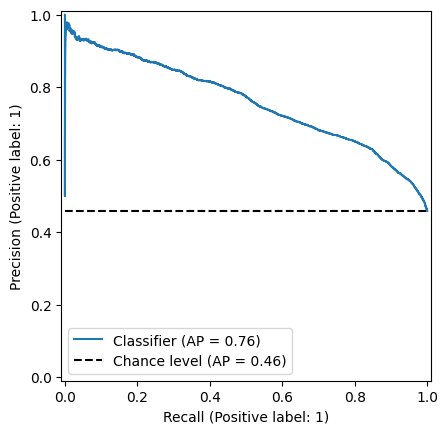

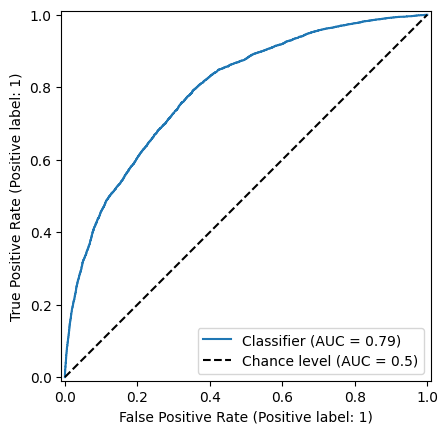

In [12]:
PrecisionRecallDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)
RocCurveDisplay.from_predictions(test.sex.values, test_pred.data[:, 0], plot_chance_level=True)

Посчитаем точность с лучшим порогом

In [13]:
best_tr = 0
best_ac = 0
for tr in np.linspace(0.0, 1.0, 1001):
    if True:
        ac = accuracy_score(test.sex.values, test_pred.data[:, 0] > tr)
        if best_ac < ac:
            best_ac = ac
            best_tr = tr
            
best_ac

0.7145317186979224

## Обучение модели на предсказание возраста

In [14]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 13
TEST_SIZE = 0.2
TIMEOUT = 1000
train_pd = train.drop(columns=['age', 'viewer_uid', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']).copy()
roles = {'target': 'age_class'}
task = Task('multiclass')

automl2 = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'gpu_ids': '0'})

train_pred2 = automl2.fit_predict(train_pd, roles=roles, verbose=1)
test_pred2 = automl2.predict(test.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))
train_pred2 = automl2.predict(train.drop(columns=['age_class', 'viewer_uid', 'age', 'sex', 'med_age_prod', 'total_watchtime_prod', 'latitude_prod', 'longitude_prod', 'duration_prod']))

[06:24:37] Stdout logging level is INFO.
[06:24:37] Task: multiclass

[06:24:37] Start automl preset with listed constraints:
[06:24:37] - time: 1000.00 seconds
[06:24:37] - CPU: 4 cores
[06:24:37] - memory: 16 GB

[06:24:37] Train data shape: (162010, 319)




libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 

libgomp: Invalid value for environment variable OMP_NUM_THREADS


[06:25:18] Layer 1 train process start. Time left 958.60 secs
[06:25:24] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[06:27:15] Time limit exceeded after calculating fold 0

[06:27:15] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.038002193655296
[06:27:15] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[06:27:15] Time left 842.43 secs

[06:28:25] Selector_LightGBM fitting and predicting completed
[06:28:29] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[06:30:22] Time limit exceeded after calculating fold 1

[06:30:22] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.0319356624635274
[06:30:22] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[06:30:22] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[06:31:58] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.0312153324279725
[06:31:58] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[06:31:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...

In [15]:
f1_weighted = f1_score(test.age_class.values, np.argmax(test_pred2.data, axis=1), average='weighted')
f1_weighted

0.46403515190963324

Посчитаем итоговый скор

In [16]:
final_score = 0.7 * f1_weighted + 0.3 * best_ac
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {best_ac:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4640 
Accuracy = 0.7145 
Final Score = 0.5392


In [23]:
joblib.dump(automl, 'model_sex.pkl') # сохранение моделей
joblib.dump(automl2, 'model_age.pkl')

['model_age.pkl']

# Analyze

Посмотрим на фичи, которые оказали наибольшее влияние на предсказание таргетных переменных

<Axes: xlabel='Feature'>

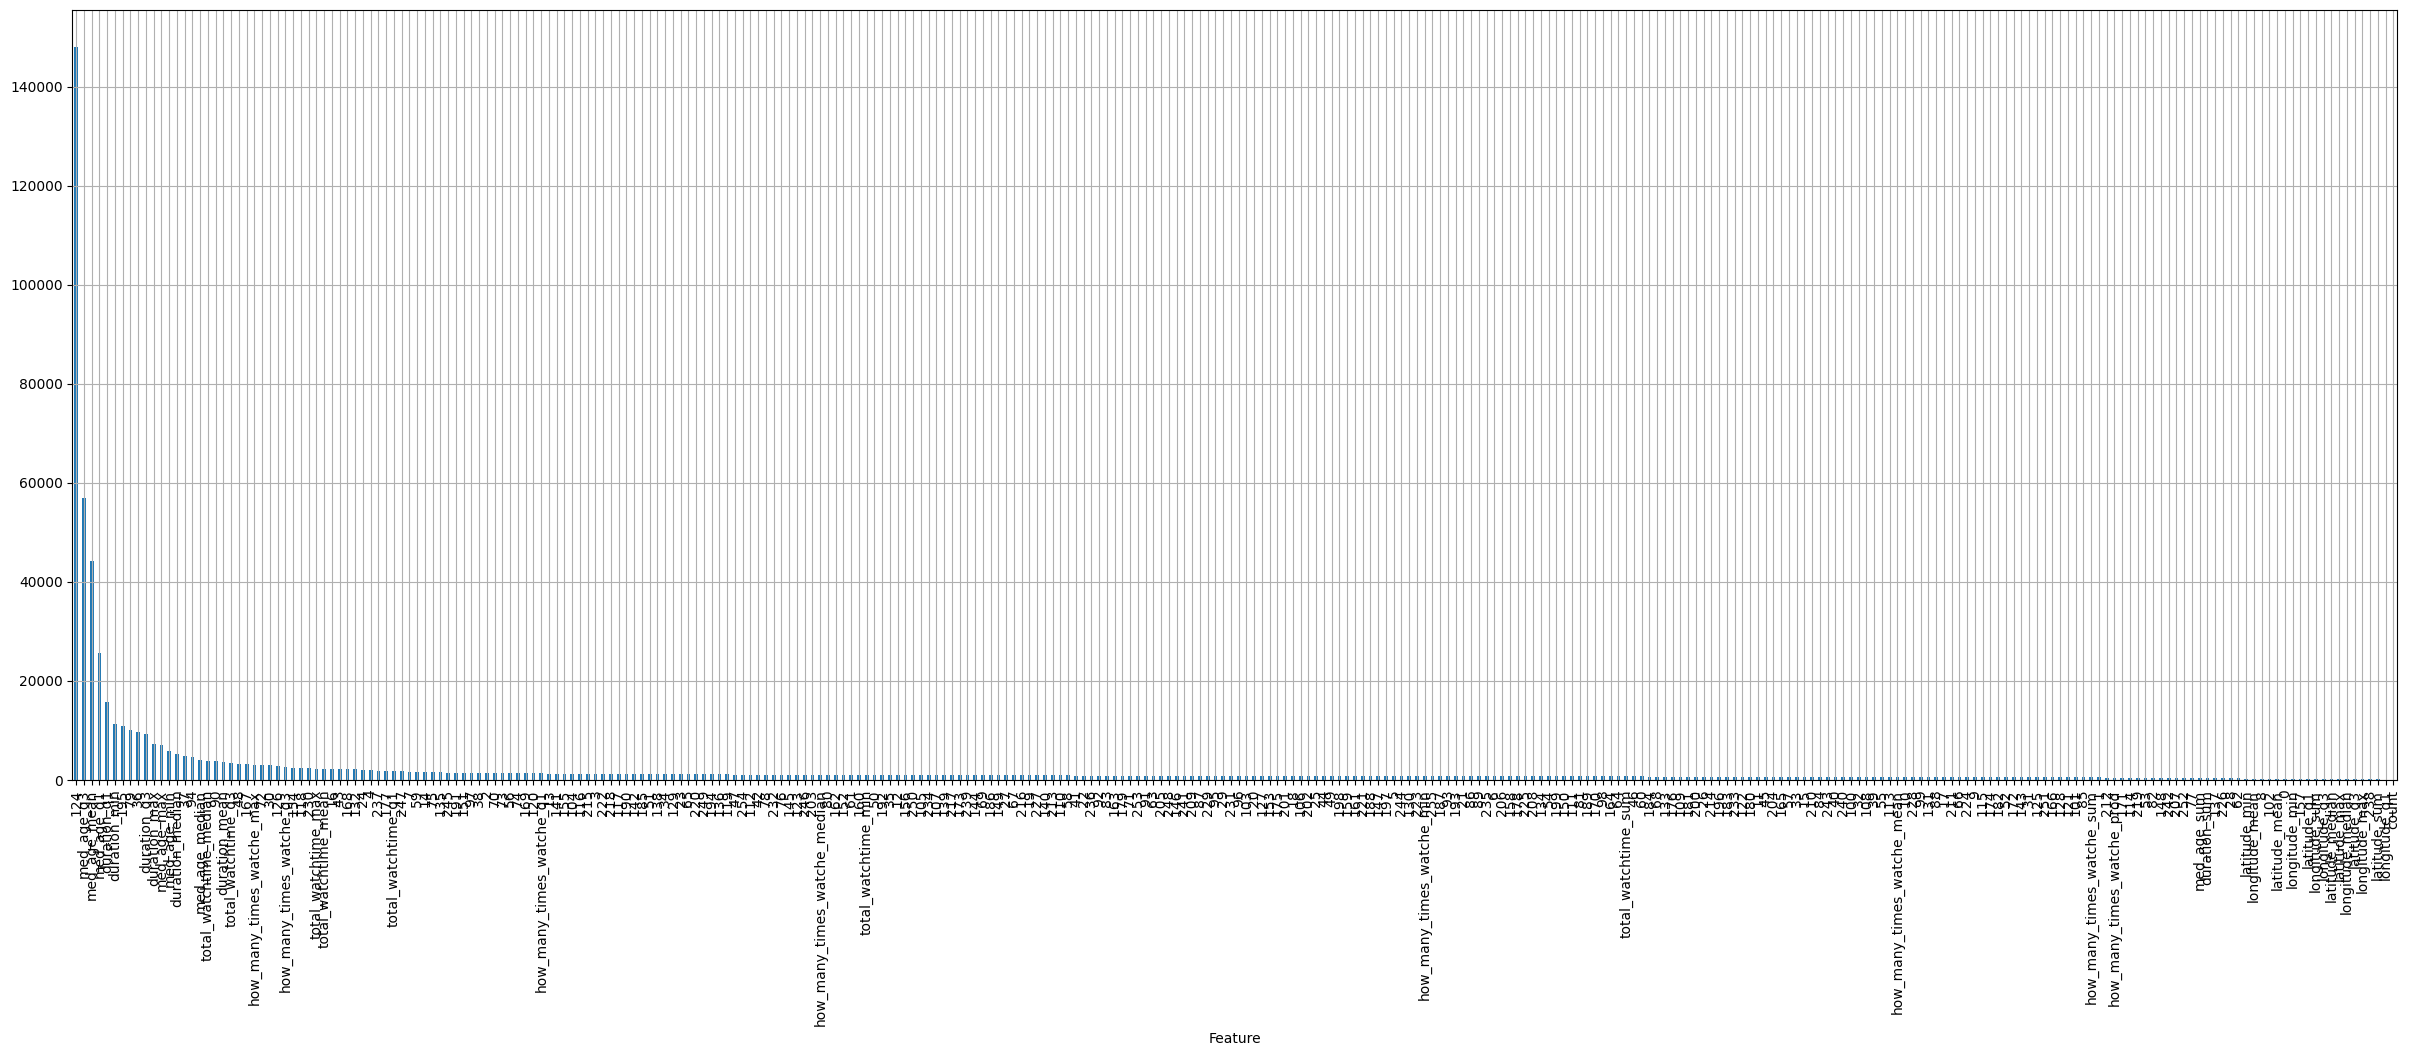

In [21]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

<Axes: xlabel='Feature'>

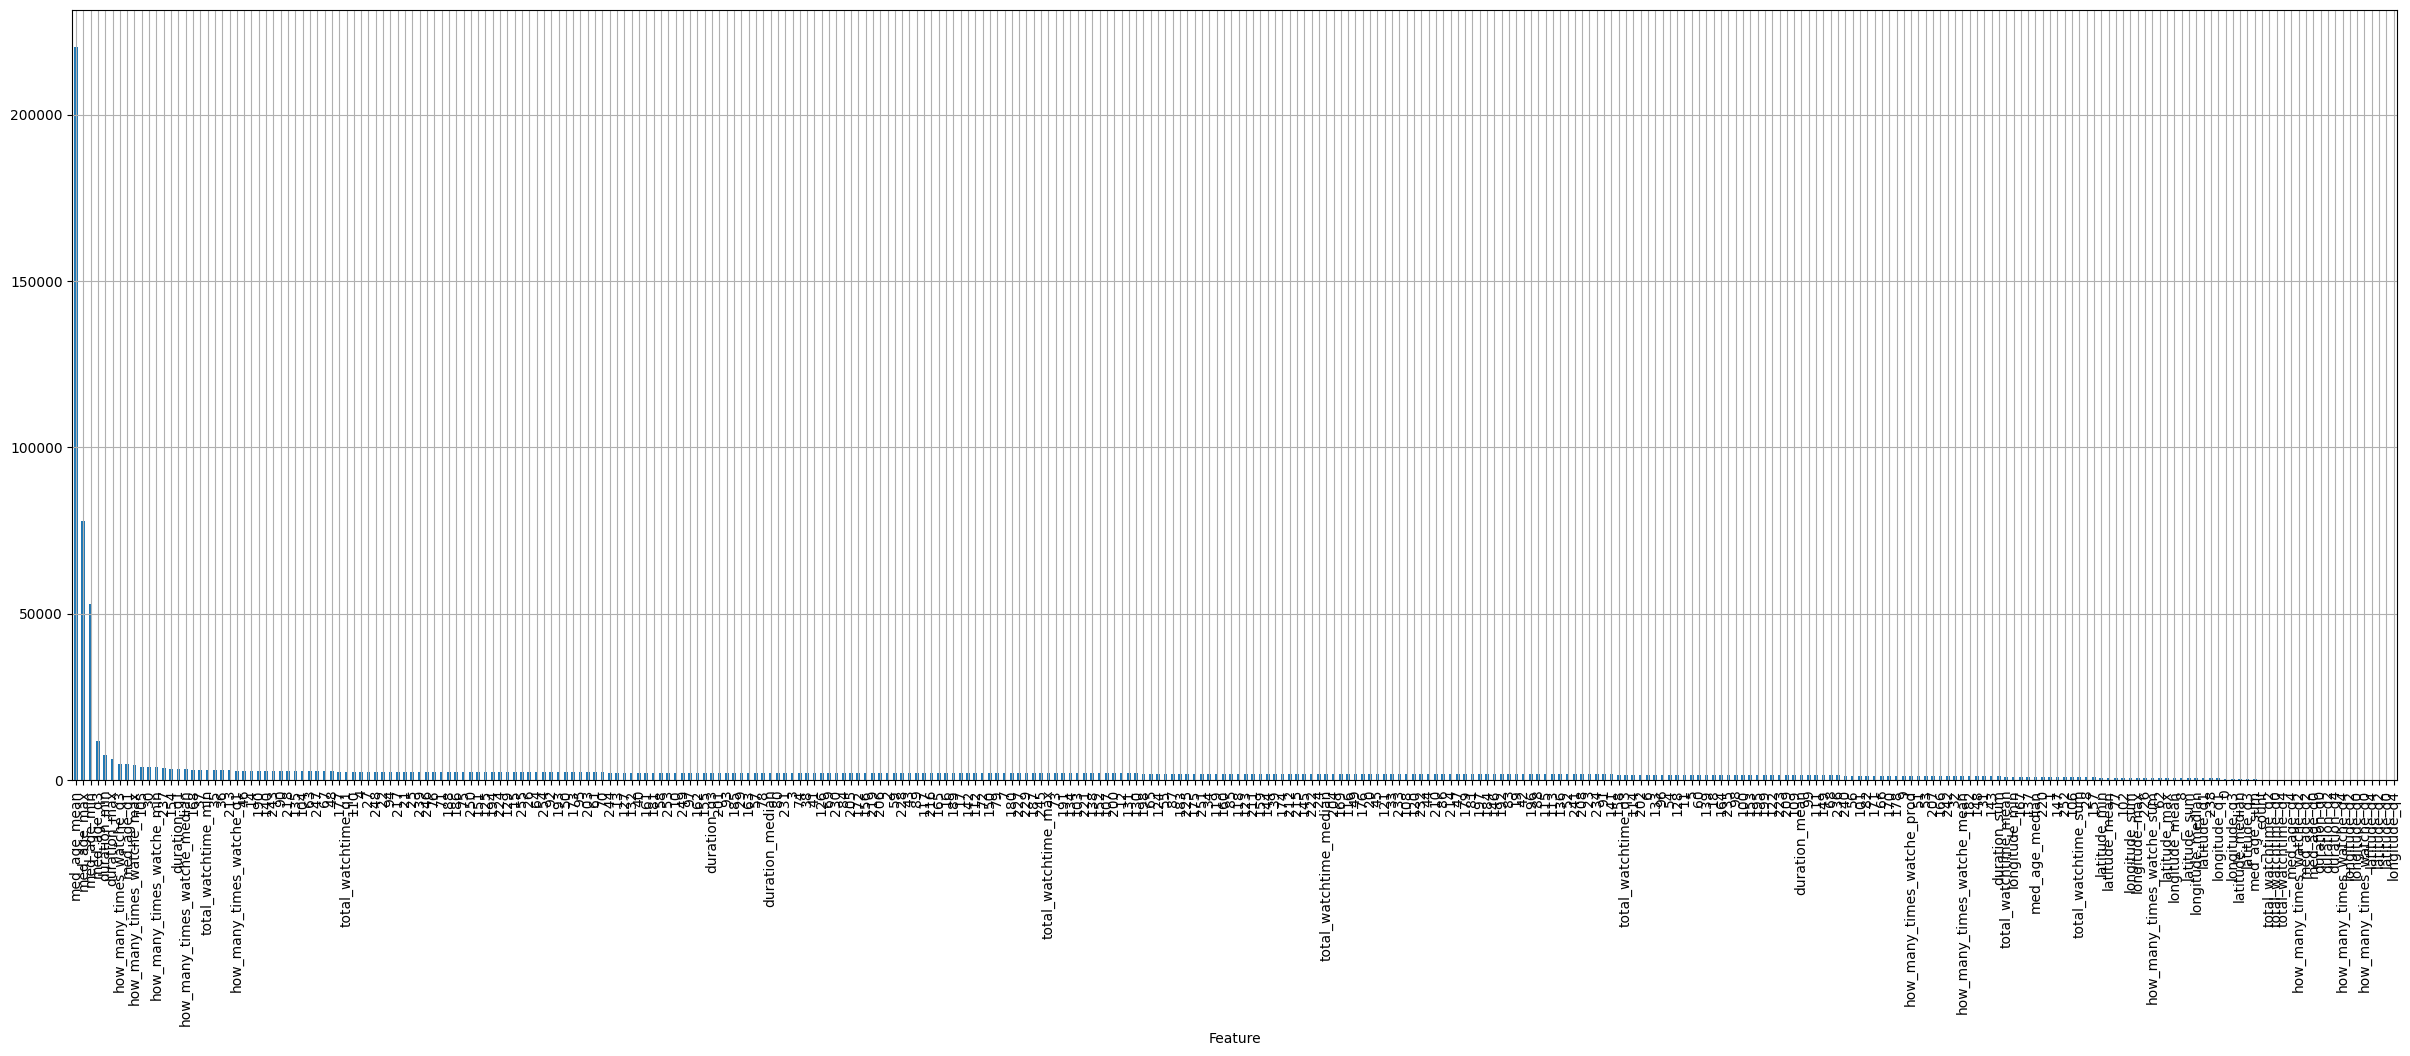

In [22]:
fast_fi = automl2.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)